In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install --upgrade pip
# !pip install --upgrade tensorflow

In [3]:
# !pip install -q efficientnet

In [4]:
!nvidia-smi

Fri Apr  1 15:08:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import

In [5]:
import os
import sys
import csv
import pickle
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers
# from tensorflow.keras.regularizers import l2
# from sklearn.model_selection import train_test_split, StratifiedKFold

import efficientnet.tfkeras as efn

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# Фиксируем окружение

In [6]:
!pip freeze > requirements.txt

# Основные настройки

In [7]:
EPOCHS               = 5    # эпох на обучение
BATCH_SIZE           = 64   # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-3 # скорость обучения
VAL_SPLIT            = 0.2  # 20% данных выделяем на тест

CLASS_NUM            = 10   # количество классов в нашей задаче
IMG_SIZE             = 120  # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3    # у RGB 3 канала
INPUT_SHAPE          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = os.path.join(os.getcwd(), 'input')     # директория с данными
PATH = os.path.join(os.getcwd(), 'working', 'car') # рабочая директория

In [8]:
# создаём рабочую директорию
os.makedirs(PATH, exist_ok=True)

# Устаналиваем конкретное значение random seed для воспроизводимости
RANDOM_SEED = 13
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# Версии

In [9]:
print(os.listdir(DATA_PATH))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['sample-submission.csv', 'train.csv', 'train.zip', 'test.zip']
Python       : 3.7.13 (default, Mar 16 2022, 17:37:17) 
Numpy        : 1.21.5
Tensorflow   : 2.8.0
Keras        : 2.8.0


# EDA / Анализ данных

In [10]:
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
sample_submission = pd.read_csv(os.path.join(DATA_PATH, 'sample-submission.csv'))

In [11]:
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [13]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

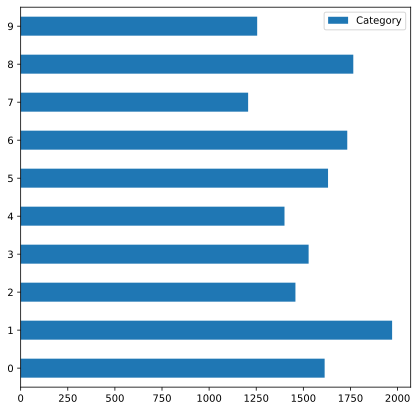

In [14]:
pd.DataFrame(train_df['Category'].value_counts(sort=False)).plot(kind='barh', figsize=(7, 7))

Распределение классов достаточно равномерное.

In [15]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile(os.path.join(DATA_PATH, data_zip),"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['train', 'test_upload']


In [16]:
def veiw_random_images(random_image_paths, random_image_cat):
    for index, path in enumerate(random_image_paths):
        im = PIL.Image.open(os.path.join(PATH, 'train', str(random_image_cat[index]), str(path)))
        plt.subplot(3,3, index+1)
        plt.subplots_adjust(hspace=0.5)
        plt.imshow(im)
        plt.title('Class: ' + str(random_image_cat[index]))
    plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжать.

Пример картинок


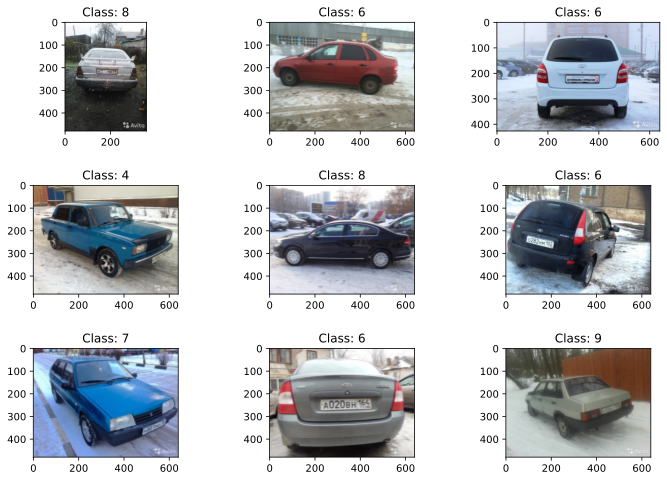

In [17]:
print('Пример картинок')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

veiw_random_images(random_image_paths, random_image_cat)

Изображения вполне различимы. Имеют разный размер.

Посмотрим на изображения одного класса.

Пример картинок одного класса


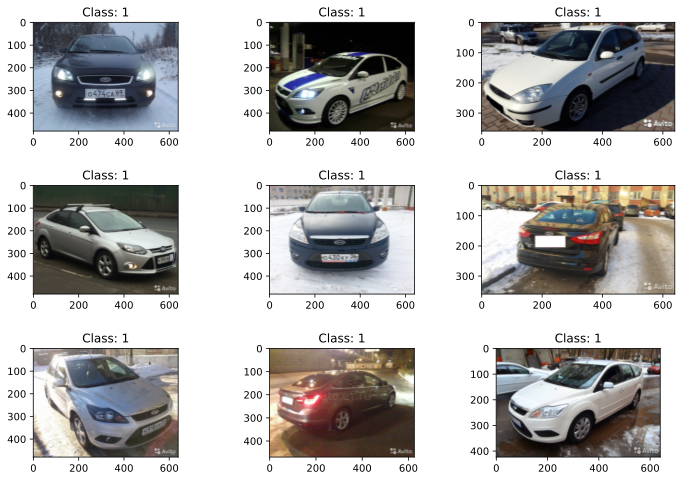

In [18]:
print('Пример картинок одного класса')
plt.figure(figsize=(12,8))

random_image = train_df.loc[train_df['Category'] == 1].sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

veiw_random_images(random_image_paths, random_image_cat)

Очевидно что класс это модель автомобиля. 

# Подготовка данных

### Аугментация данных

Т.к. данных относительно не много, следует прибегнуть к аугментации данных.  
Чтобы экономить ресурсы железа создадим генератор, который будет подавать в модель изображения порциями.  
За аугментацию так же будет отвечать генератор.  

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    brightness_range=(0.2, 0.8),
    shear_range=0.2,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

#Рекомендация Подключите более продвинутые библиотеки аугментации изображений (например: albumentations или imgaug, для них есть специальные "обертки" под Keras, например: https://github.com/mjkvaak/ImageDataAugmentor)

### Генерация данных

In [20]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    os.path.join(PATH, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    os.path.join(PATH, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=os.path.join(PATH, 'test_upload'),
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


Данные разбиты корректно: в каждой группе равное количество классов.

# Посмотрим аугментацию данных.

Пример аугментированных картинок из train_generator


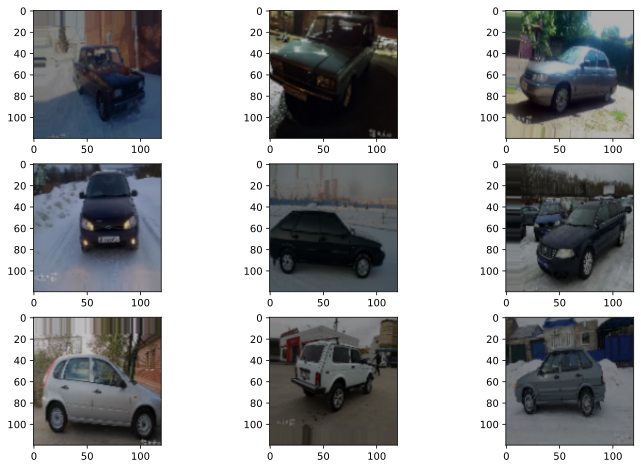

In [21]:
from skimage import io

def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()

x,y = train_generator.next()
print('Пример аугментированных картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,9):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
plt.show()

# Построение модели

### Загружаем предобученную на ImageNet сеть EfficientNetB6:

In [22]:
# base_model = Xception(weights='imagenet', include_top=False, input_shape = INPUT_SHAPE)
base_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

In [23]:
base_model.summary()

Model: "efficientnet-b6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 60, 60, 56)   1512        ['input_1[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 60, 60, 56)   224         ['stem_conv[0][0]']              
                                                                                                  
 stem_activation (Activation)   (None, 60, 60, 56)   0           ['stem_bn[0][0]']  

# Fine-tuning. Обучение модели.

### Этап первый.  
Отключаем обучение подгруженной сети.

In [24]:
# Fine-tuning
base_model.trainable = False

Устанавливаем новую "голову".

In [57]:
model=M.Sequential()
model.add(base_model)
model.add(L.MaxPooling2D(),)
model.add(L.BatchNormalization())
model.add(L.Dense(CLASS_NUM, activation='softmax'))

TypeError: ignored

In [ ]:
model.summary()

In [27]:
# сколько слоев
print(len(model.layers))

3


Проверим что подгруженная сеть не будет обучаться.

In [28]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.functional.Functional object at 0x7f1d805e5910> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f1d805ee750> True
<keras.layers.core.dense.Dense object at 0x7f1d848839d0> True


Обучаем.

In [49]:
LR=0.001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adamax(lr=LR), metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [50]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [51]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ValueError: ignored

In [52]:
# history = model.fit_generator(
#     train_generator,
#     steps_per_epoch = len(train_generator),
#     validation_data = test_generator, 
#     validation_steps = len(test_generator),
#     epochs = EPOCHS,
#     callbacks = callbacks_list
#     )


history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples//train_generator.batch_size,
    validation_data = test_generator, 
    validation_steps = test_generator.samples//test_generator.batch_size,
    epochs = 10,
    callbacks = callbacks_list
    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ValueError: ignored

In [ ]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

Посмотрим график обучения.

In [ ]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

### Этап второй.  
Посмотрим сколько слоёв в модели.

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Разморозим половину слоёв.

In [ ]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Посмотрим сколько слоёв будет обучаться.

In [ ]:
len(base_model.trainable_variables)

Проверяем что подгруженная сеть тоже включается в обучение.

In [ ]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

Обучаем.

In [ ]:
LR=0.0001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adamax(lr=LR), metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples//train_generator.batch_size,
    validation_data = test_generator, 
    validation_steps = test_generator.samples//test_generator.batch_size,
    epochs = 10,
    callbacks = callbacks_list
    )

In [ ]:
model.save('../working/model_step2.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
plot_history(history)

### Этап третий.
Обучаем все слои.

In [ ]:
base_model.trainable = True

In [ ]:
LR=0.00001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adamax(lr=LR), metrics=["accuracy"])

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples//train_generator.batch_size,
    validation_data = test_generator, 
    validation_steps = test_generator.samples//test_generator.batch_size,
    epochs = 10,
    callbacks = callbacks_list
    )

In [ ]:
model.save('../working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
plot_history(history)

### Этап четвёртый.

In [ ]:
EPOCHS               = 10
BATCH_SIZE           = 4 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-4

IMG_SIZE             = 512
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [ ]:
raise KeyboardInterrupt

В Итоге точность нашей модели составила XX%.   
Учитывая что классов 10 - это Очень хороший результат!     

# Предсказание на тестовых данных

In [ ]:
test_sub_generator.samples

In [ ]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

# Рекомендация: попробуйте добавить Test Time Augmentation (TTA)
# https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d

In [ ]:
submission.head()

In [ ]:
# Clean PATH
import shutil
shutil.rmtree(PATH)

* Примените transfer learning с fine-tuning
* Настройте LR, optimizer, loss
* Подберите другие переменные (размер картинки, батч и т.д.)
* Попробуйте и другие архитектуры сетей (а не только Xception) или их ансамбли. Примеры SOTA на ImageNet  
* 
* Добавьте Batch Normalization и поэкспериментируйте с архитектурой “головы”
* Примените другие функции callback Keras https://keras.io/callbacks/ 
* Добавьте TTA (Test Time Augmentation)
* Дополнительно*: Используйте разные техники управления Learning Rate (https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6 (eng) http://teleported.in/posts/cyclic-learning-rate/ (eng))
* Дополнительно*: Добавьте более продвинутые библиотеки аугментации изображений (например, Albumentations )

### Удачи в соревновании!